In [48]:
#Load photos
import numpy as np
photos=np.load('mypicture.npy')
import cv2
#Show a picture
cv2.imshow('1',photos[0])
cv2.waitKey(0)

-1

In [51]:
import pandas as pd
df = pd.read_csv('label.csv')
df.head(10)

,mypath,label(o=inside)
0,Pic_1_89895656.jpg,1
1,Pic_1_89895754.jpg,1
2,Pic_1_89895880.jpg,1
3,Pic_1_89896055.jpg,1
4,Pic_1_89896158.jpg,1
5,Pic_1_89896260.jpg,1
6,Pic_1_89896276.jpg,1
7,Pic_1_89896392.jpg,1
8,Pic_1_89896439.jpg,1
9,Pic_1_89896541.jpg,1


In [52]:
mylabel=df['label(o=inside)'] #1 is outside , o is inside
len(mylabel) , len(photos)

(1077, 1077)

In [53]:
from random import shuffle 
from tqdm import tqdm 

'''Labelling the dataset'''

def label_img(l):     
    # Tranform label from 1 dimension into 2 dimension
    if l == 0: return [1, 0]  #inside
    elif l == 1: return [0, 1] #Outside
mylabel_2d=[]
for i in mylabel:
    mylabel_2d.append(label_img(i))
mylabel_2d[0:5]


[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]

In [54]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(photos, mylabel_2d ,  test_size=0.1)

In [55]:
'''Creating the training data'''
def create_train_data(): 
    # Creating an empty list where we should store the training data 
    training_data = [] 
    
    # tqdm is only used for interactive loading 
    # loading the training data 
    for i in tqdm(range(0,len(train_x))): 
        # form the training data list with numpy array of the images 
        training_data.append([np.array(train_x[i]), np.array(train_y[i])])
        
    # shuffling of the training data to preserve the random state of our data 
    shuffle(training_data) 
    
    # saving our trained data for further uses if required 
    np.save('train_data.npy', training_data) 
    return training_data

train_data = create_train_data() 


100%|██████████| 969/969 [00:00<00:00, 2322.26it/s]


In [56]:
'''Processing the given test data'''
# Almost same as processing the training data but 
# we dont have to label it. 
def process_test_data(): 
    # Creating an empty list where we should store the training data 
    testing_data = [] 
    
    # tqdm is only used for interactive loading 
    # loading the training data 
    for i in tqdm(range(0,len(valid_x))): 
        # form the training data list with numpy array of the images 
        testing_data.append([np.array(valid_x[i]), np.array(valid_y[i])])
        
    # shuffling of the training data to preserve the random state of our data 
    shuffle(testing_data) 
    
    # saving our test data for further uses if required 
    np.save('test_data.npy', testing_data) 
    return testing_data

test_data = process_test_data() 

100%|██████████| 108/108 [00:00<00:00, 1320.62it/s]


In [58]:
# train_data = np.load('train_data.npy') 
# test_data = np.load('test_data.npy') 
'''Creating the neural network using tensorflow'''
# Importing the required libraries 
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.core import input_data, dropout, fully_connected 
from tflearn.layers.estimator import regression 

In [59]:
import tensorflow as tf
LR = 1e-3
tf.reset_default_graph() 
convnet = input_data(shape =[None, 300, 300, 3], name ='input') 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = fully_connected(convnet, 1024, activation ='relu') 
convnet = dropout(convnet, 0.8) 
  
convnet = fully_connected(convnet, 2, activation ='softmax') 
convnet = regression(convnet, optimizer ='adam', learning_rate = LR, 
      loss ='categorical_crossentropy', name ='targets') 
  
model = tflearn.DNN(convnet, tensorboard_dir ='log') 
 

In [60]:
# Splitting the testing data and training data 
train = train_data[:int(0.8*len(train_data))] 
test = train_data[int(0.8*len(train_data)):] 
  
'''Setting up the features and lables'''
# X-Features & Y-Labels 
IMG_SIZE=300
  
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)  #3 because we have 3 RGB for each pixel, it would be 1 if for grey scale picture
Y = [i[1] for i in train] 
mytest_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 3) 
mytest_y = [i[1] for i in test] 


In [71]:
'''Setting up the model which will help with tensorflow models'''
MODEL_NAME = '2inside-VS-outside-{}-{}.model'.format(LR, '6conv-basic')

'''Fitting the data into our model'''

model.fit({'input': X}, {'targets': Y}, n_epoch = 30,  
    validation_set =({'input': mytest_x}, {'targets': mytest_y}),  
    snapshot_step = 400, show_metric = True, run_id = MODEL_NAME) 
model.save(MODEL_NAME) 

Training Step: 454  | total loss: 0.36474 | time: 151.868s
| Adam | epoch: 035 | loss: 0.36474 - acc: 0.9376 -- iter: 768/775
Training Step: 455  | total loss: 0.33127 | time: 177.873s
| Adam | epoch: 035 | loss: 0.33127 - acc: 0.9438 | val_loss: 0.05552 - val_acc: 0.9845 -- iter: 775/775
--
INFO:tensorflow:C:\Users\VoramatePasharawipas\Desktop\MSA-MRM GSU\job\GRA_FALL2019\Image\2inside-VS-outside-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [72]:
#Print out to see probability of prediction 
import matplotlib.pyplot as plt 
test_data = np.load('test_data.npy', allow_pickle=True) 
  
fig = plt.figure() 
 
IMG_SIZE=300

for num, data in enumerate(test_data[:50]): 
    # Inside: [1, 0] 
    # Outside: [0, 1] 
      
  
    img_data = data[0] 
    
    
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 3) 
  
    model_out = model.predict([data])[0] 
    print (num , model_out[np.argmax(model_out)] , np.argmax(model_out), model_out)
#See where to Set cutoff that could distingush between inside and outside the best (in case of unbalance data se)


0 0.9913119 1 [0.00868818 0.9913119 ]
1 0.9903246 1 [0.00967542 0.9903246 ]
2 0.9786485 0 [0.9786485  0.02135151]
3 0.99442154 1 [0.0055785  0.99442154]
4 0.9943488 0 [0.9943488  0.00565121]
5 0.98162866 0 [0.98162866 0.01837129]
6 0.9965719 0 [0.9965719  0.00342809]
7 0.94145817 0 [0.94145817 0.05854182]
8 0.9636022 0 [0.9636022  0.03639777]
9 0.9687007 1 [0.03129932 0.9687007 ]
10 0.9789097 0 [0.9789097  0.02109031]
11 0.99766904 0 [0.99766904 0.00233099]
12 0.96789294 0 [0.96789294 0.03210705]
13 0.9911145 0 [0.9911145  0.00888544]
14 0.9694838 1 [0.03051616 0.9694838 ]
15 0.98703545 0 [0.98703545 0.01296456]
16 0.9735798 0 [0.9735798  0.02642017]
17 0.98848 1 [0.01152003 0.98848   ]
18 0.9898163 1 [0.01018366 0.9898163 ]
19 0.93774086 1 [0.06225908 0.93774086]
20 0.95212793 0 [0.95212793 0.04787207]
21 0.9725772 0 [0.9725772  0.02742274]
22 0.9773077 0 [0.9773077  0.02269237]
23 0.97737247 1 [0.0226275  0.97737247]
24 0.5062073 0 [0.5062073  0.49379268]
25 0.9621968 1 [0.03780314 0

<Figure size 432x288 with 0 Axes>

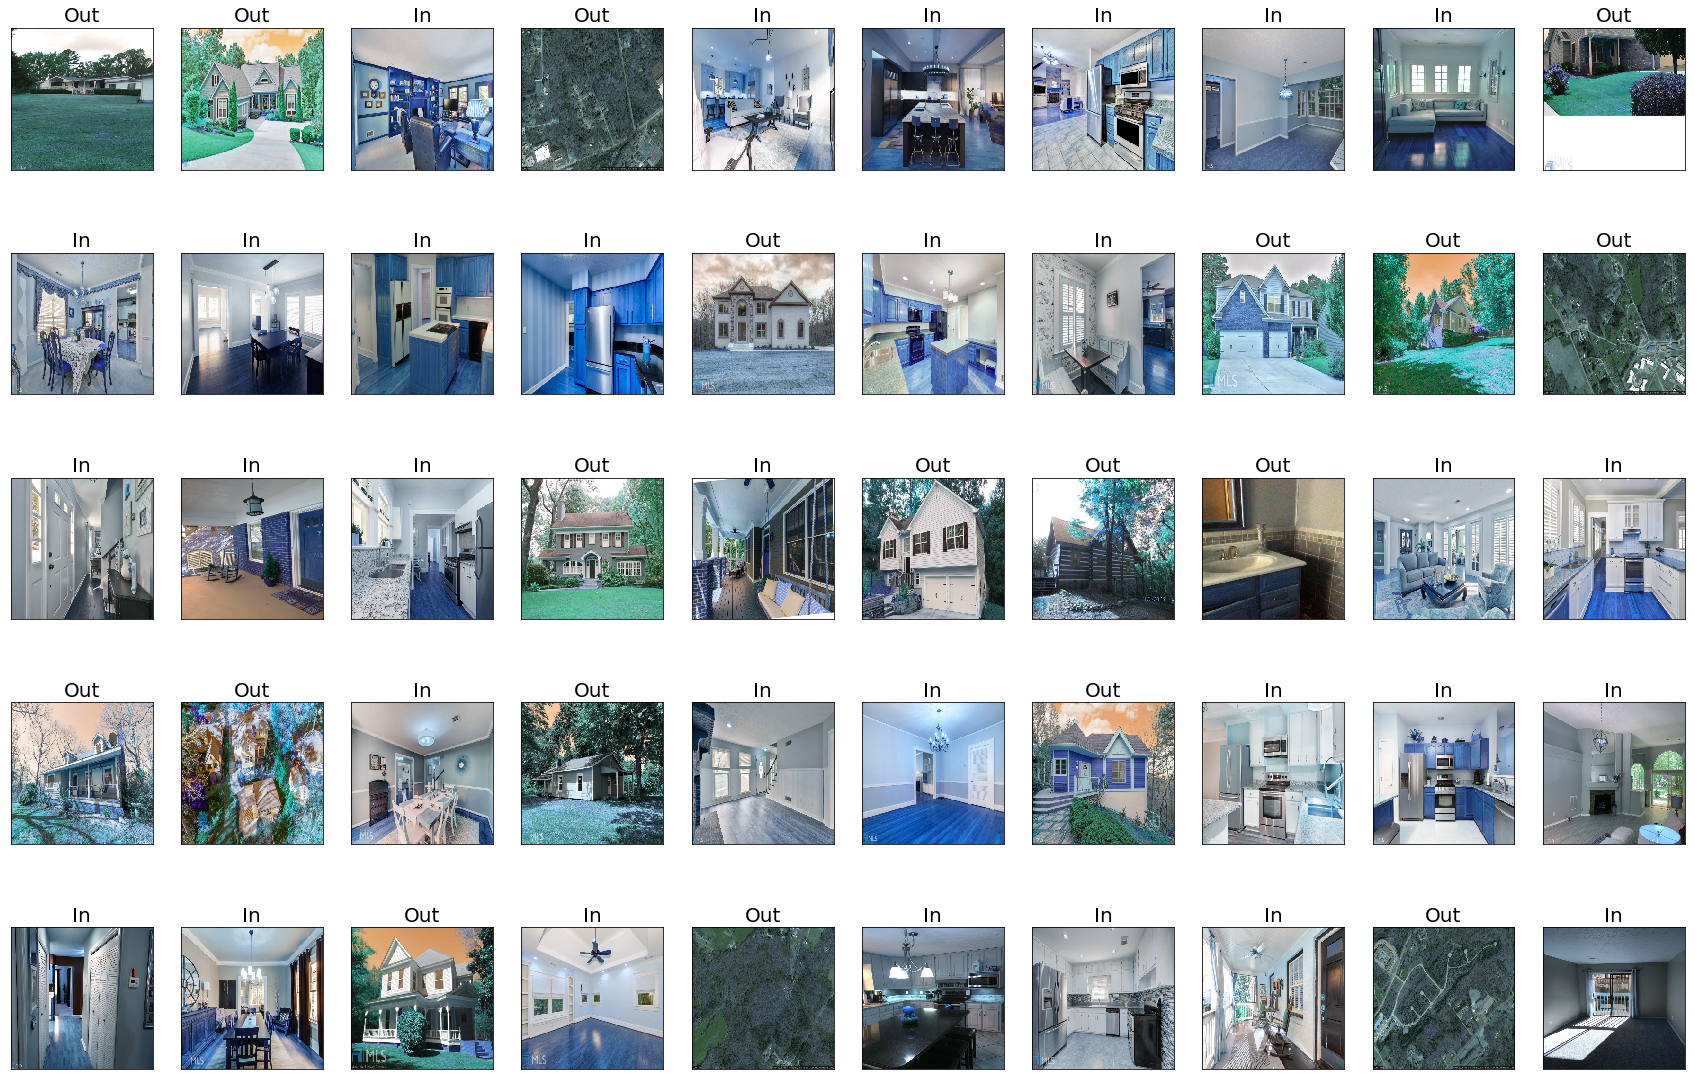

In [86]:
'''Testing the data'''
import matplotlib.pyplot as plt 
# if you need to create the data: 
# test_data = process_test_data() 
# if you already have some saved: 
test_data = np.load('test_data.npy', allow_pickle=True)
  
fig = plt.figure(figsize=(30,20)) 
  
for num, data in enumerate(test_data[:50]): 
    # Inside: [1, 0] 
    # Outside: [0, 1] 
      
    img_data = data[0] 
      
    y = fig.add_subplot(5, 10, num + 1) 
    orig = img_data 
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 3) 
   
    model_out = model.predict([data])[0] 
      
    if (np.argmax(model_out) ==0) : 
        str_label ='In'
    else: 
        str_label ='Out'
          
    y.imshow(orig) 
    plt.title(str_label , fontsize=20) 
    y.axes.get_xaxis().set_visible(False) 
    y.axes.get_yaxis().set_visible(False) 
plt.show() 

In [74]:
'''
import matplotlib.pyplot as plt 
# if you need to create the data: 
# test_data = process_test_data() 
# if you already have some saved: 
test_data = np.load('test_data.npy', allow_pickle=True)
  
fig = plt.figure(figsize=(30,20)) 
  
for num, data in enumerate(test_data[:50]): 
    # Inside: [1, 0] 
    # Outside: [0, 1] 
      
    img_data = data[0] 
      
    y = fig.add_subplot(5, 10, num + 1) 
    orig = img_data 
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 3) 
  
    # model_out = model.predict([data])[0] 
    model_out = model.predict([data])[0] 
      
    if (np.argmax(model_out) ==0) and (model_out[np.argmax(model_out)] >= 0.9): #Set cutoff at 0.9 give the best result
        str_label ='In'
    else: 
        str_label ='Out'
          
    y.imshow(orig) 
    plt.title(str_label) 
    y.axes.get_xaxis().set_visible(False) 
    y.axes.get_yaxis().set_visible(False) 
plt.show() 
'''

"\nimport matplotlib.pyplot as plt \n# if you need to create the data: \n# test_data = process_test_data() \n# if you already have some saved: \ntest_data = np.load('test_data.npy', allow_pickle=True)\n  \nfig = plt.figure(figsize=(30,20)) \n  \nfor num, data in enumerate(test_data[:50]): \n    # Inside: [1, 0] \n    # Outside: [0, 1] \n      \n    img_data = data[0] \n      \n    y = fig.add_subplot(5, 10, num + 1) \n    orig = img_data \n    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 3) \n  \n    # model_out = model.predict([data])[0] \n    model_out = model.predict([data])[0] \n      \n    if (np.argmax(model_out) ==0) and (model_out[np.argmax(model_out)] >= 0.9): #Set cutoff at 0.9 give the best result\n        str_label ='In'\n    else: \n        str_label ='Out'\n          \n    y.imshow(orig) \n    plt.title(str_label) \n    y.axes.get_xaxis().set_visible(False) \n    y.axes.get_yaxis().set_visible(False) \nplt.show() \n"

In [75]:
cv2.imshow('1',test_data[29][0])
cv2.waitKey(0)

-1

In [85]:
####### Find accuracy #####

#Create list of predited value to compare with validation dataset
for_checking=[] 
for num, data in enumerate(test_data): 
    # Inside: [1, 0] 
    # Outside: [0, 1] 
      
    img_data = data[0]       
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 3) 
    model_out = model.predict([data])[0] 
      
    if (np.argmax(model_out) ==0) :
        for_checking.append([1,0])
    else: 
        for_checking.append([0,1])
#Compare with validation dataset       
number_of_correct=0
for i in range(0,len(test_data)):
    if np.array_equal(for_checking[i], test_data[i][1]):
        number_of_correct+=1
print ('CNN accuracy is: '+str(number_of_correct / len(for_checking)*100) +'%')

CNN accuracy is: 98.14814814814815%


In [ ]:
#To Load trained model 
model.load('inside-VS-outside-0.001-6conv-basic.model')